In [1]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
import multiprocessing as mp
import dill
from matplotlib.ticker import StrMethodFormatter
# Set the random seed
np.random.seed(42)

In [38]:
# Set up some helper functions
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def plot_lake_values(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, "{:.4f}".format(policy[i, j]),
                               horizontalalignment='center', size=8, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    return ave_steps, std_steps, pct_fail

In [5]:
# Define a custom map for 16x16 grid world
MAPS = {
    "4x4": [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
    ],
    
    "16x16": [
    "SFFFFFFHFFFHHFFF",
    "FFFFFFFFFFFFFFFF",
    "FHHHFFFFFFFHFFFF",
    "FFHFHHFHFFFFFFHF",
    "FFFHFHFFFHFFFFFF",
    "HFFFFFFFHFFFFFFF",
    "FFFFFFFFHFFFFFFF",
    "HHFHHFHFHHFFFFHH",
    "FFFFFFHFFFFHHFFF",
    "FFFFFFHFFFHFFFFF",
    "FFFFFHFFFFFFFFFF",
    "FFHFFFHHFFHFFFFH",
    "HFFFFHHFFFFHFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFHFHFFFFFFFFFFF",
    "HHHFFHFHHHFFHFFG",
    ]
}

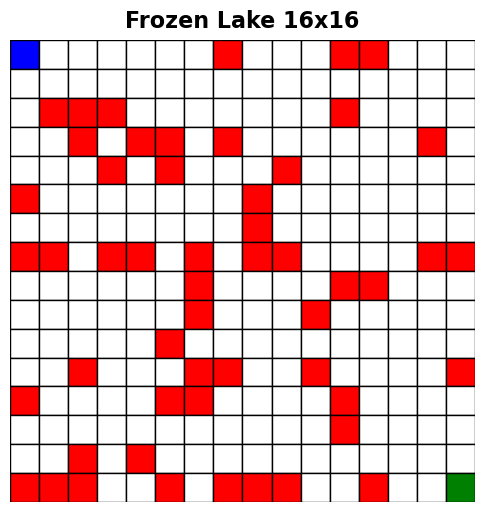

In [7]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True).unwrapped
# Need to change the values based on number of rows and columns

rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            

plot_lake(env, policy=None, title = 'Frozen Lake 16x16')

In [16]:
def trainPI_2(P, R, discount=0.9, epsilon =0.001):
    pi_df = pd.DataFrame(columns=['Epsilon','Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",
                                  'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    pi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            pi = PolicyIterationModified(P, R, gamma=gamma, epsilon = eps, )
            pi_run = pi.run()
            pi_run_df = pd.DataFrame(pi_run)
            pi_run_df['Eps'] = str(float(eps))
            pi_run_df['Gamma'] = str(float(gamma))
            
            #print(pi_run_df)

            reward = max(pi_run_df['Reward'])
            steps, steps_stddev, failures = get_score(env, pi.policy, None)
            info = [float(eps), float(gamma), pi.policy, pi.iter, pi.time, reward,
                    pi.V,
                    steps,steps_stddev,
                    #Success is 100% - failure%
                    100-failures
                   ]
            df_length = len(pi_df)
            pi_df.loc[df_length] = info

            pi_run_full = pd.concat([pi_run_full,pi_run_df])
            
    return pi_df, pi_run,pi,pi_run_full


def trainPI_3(P, R, discount=0.9, epsilon =0.001):
    pi_df = pd.DataFrame(columns=['Epsilon','Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",
                                  #'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    pi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            pi = PolicyIterationModified(P, R, gamma=gamma, epsilon = eps, )
            pi_run = pi.run()
            pi_run_df = pd.DataFrame(pi_run)
            pi_run_df['Eps'] = str(float(eps))
            pi_run_df['Gamma'] = str(float(gamma))
            
            #print(pi_run_df)

            reward = max(pi_run_df['Reward'])
            #steps, steps_stddev, failures = get_score(env, pi.policy, None)
            info = [float(eps), float(gamma), pi.policy, pi.iter, pi.time, reward,
                    pi.V,
                    #steps,steps_stddev,
                    #Success is 100% - failure%
                    #100-failures
                   ]
            df_length = len(pi_df)
            pi_df.loc[df_length] = info

            pi_run_full = pd.concat([pi_run_full,pi_run_df])
            
    return pi_df, pi_run,pi,pi_run_full

In [9]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

pi_df,pi_policy,pi_run,pi_run_full = trainPI_2(T, R, discount= discount, epsilon=epsilon)
pi_df

Wall time: 2min 53s


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function,Avg_Steps,Steps_StDev,Success_Rate
0,1.000000e-03,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.009824,0.418725,"(-0.01999999967840553, -0.020000000986761534, ...",2905.383673,2425.560601,73.5
1,1.000000e-05,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.009084,0.418725,"(-0.01999999967840553, -0.020000000986761534, ...",2759.586926,2254.459490,71.9
2,1.000000e-07,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.010469,0.418725,"(-0.019999999678398935, -0.020000000986744038,...",2684.859864,2158.729339,73.5
3,1.000000e-03,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.016744,0.531431,"(-0.040000480350307, -0.04000072322046548, -0....",2652.120270,2012.499196,74.0
4,1.000000e-05,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.020498,0.531431,"(-0.040000480254536036, -0.040000723076854955,...",2735.965054,2213.172996,74.4
5,1.000000e-07,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.024707,0.531431,"(-0.040000480254536036, -0.040000723076854955,...",2665.247340,2017.203684,75.2
6,1.000000e-03,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.059969,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0...",2239.710067,1997.484109,74.5
7,1.000000e-05,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.054592,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0...",2235.856777,1967.114802,78.2
8,1.000000e-07,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.051588,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0...",2284.486911,2131.279071,76.4
9,1.000000e-03,0.99,"(1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.309920,0.896224,"(-0.8203400215669723, -0.813988643038715, -0.8...",214.617201,93.834918,59.3


In [17]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

pi_df,pi_policy,pi_run,pi_run_full = trainPI_3(T, R, discount= discount, epsilon=epsilon)
pi_df

Wall time: 1.12 s


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-03,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.007407,0.418725,"(-0.01999999967840553, -0.020000000986761534, ..."
1,1.000000e-05,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.009851,0.418725,"(-0.01999999967840553, -0.020000000986761534, ..."
2,1.000000e-07,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.011724,0.418725,"(-0.019999999678398935, -0.020000000986744038,..."
3,1.000000e-03,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",3,0.014798,0.531431,"(-0.040000480350307, -0.04000072322046548, -0...."
4,1.000000e-05,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.019221,0.531431,"(-0.040000480254536036, -0.040000723076854955,..."
5,1.000000e-07,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.021530,0.531431,"(-0.040000480254536036, -0.040000723076854955,..."
6,1.000000e-03,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.046879,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0..."
7,1.000000e-05,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.049985,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0..."
8,1.000000e-07,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.047439,0.680860,"(-0.10002622533976901, -0.1000305977077719, -0..."
9,1.000000e-03,0.99,"(1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",4,0.278131,0.896224,"(-0.8203400215669723, -0.813988643038715, -0.8..."


In [18]:
%%time
pi_score_df = pd.DataFrame()
pi_score_df_full = pd.DataFrame()
for i in range(0,5):
    pi_df,pi_policy,pi_run,pi_run_full = trainPI_2(T, R, discount= discount, epsilon=epsilon)
    pi_score_df = pi_df[['Epsilon','Discount','Success_Rate']]
    pi_score_df = pi_score_df.rename(columns={'Success_Rate':'Success_Rate_'+str(i)})
    pi_score_df_full = pd.concat([pi_score_df_full,pi_score_df],axis=1)

Wall time: 10min 48s


In [19]:
pi_score_df_full = pi_score_df_full.loc[:,~pi_score_df_full.columns.duplicated()].copy()

In [20]:
pi_score_df_full['Success_Mean'] = pi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].mean(axis = 1)
pi_score_df_full['Success_StdDev'] = pi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].std(axis = 1)
pi_score_df_full['Success_Max'] = pi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].max(axis = 1)

In [21]:
pi_score_df_full

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
0,1.000000e-03,0.50,76.2,76.0,71.5,74.3,75.1,74.62,1.901841,76.2
1,1.000000e-05,0.50,75.7,71.3,74.6,74.5,77.1,74.64,2.141962,77.1
2,1.000000e-07,0.50,76.8,76.5,74.8,76.0,75.4,75.90,0.812404,76.8
3,1.000000e-03,0.75,73.9,75.0,72.8,74.0,76.2,74.38,1.281405,76.2
4,1.000000e-05,0.75,74.1,78.0,75.4,73.2,74.2,74.98,1.860645,78.0
5,1.000000e-07,0.75,76.5,75.4,73.6,76.4,73.1,75.00,1.576388,76.5
6,1.000000e-03,0.90,75.5,76.5,75.0,73.5,76.1,75.32,1.167048,76.5
7,1.000000e-05,0.90,74.8,72.9,74.1,75.6,73.9,74.26,1.011435,75.6
8,1.000000e-07,0.90,76.5,73.7,75.9,77.6,75.2,75.78,1.458424,77.6
9,1.000000e-03,0.99,60.2,58.2,59.6,55.4,56.2,57.92,2.086145,60.2


In [22]:
a1 = pi_score_df_full[pi_score_df_full['Epsilon']==1.e-07]
a2 = pi_score_df_full[pi_score_df_full['Epsilon']==1.e-05]
a3 = pi_score_df_full[pi_score_df_full['Epsilon']==1.e-03]
a1

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
2,1.000000e-07,0.50,76.8,76.5,74.8,76.0,75.4,75.90,0.812404,76.8
5,1.000000e-07,0.75,76.5,75.4,73.6,76.4,73.1,75.00,1.576388,76.5
8,1.000000e-07,0.90,76.5,73.7,75.9,77.6,75.2,75.78,1.458424,77.6
11,1.000000e-07,0.99,60.3,60.0,58.4,54.5,58.9,58.42,2.325296,60.3


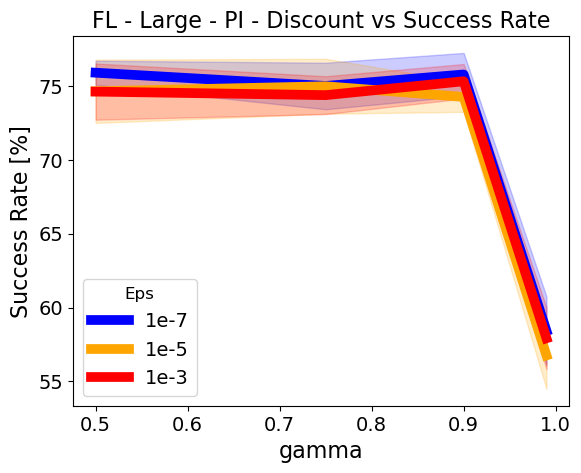

In [24]:
plt.plot(a1['Discount'],a1['Success_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Success_Mean']+a1['Success_StdDev'],a1['Success_Mean']-a1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Success_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Success_Mean']+a2['Success_StdDev'],a2['Success_Mean']-a2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Success_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Success_Mean']+a3['Success_StdDev'],a3['Success_Mean']-a3['Success_StdDev'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FL - Large - PI - Discount vs Success Rate', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

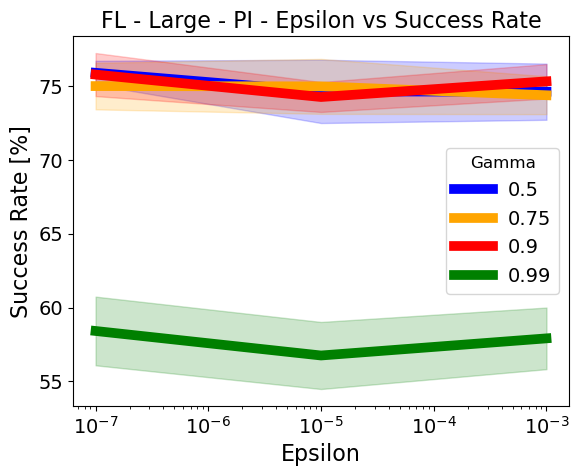

In [27]:
b1 = pi_score_df_full[pi_score_df_full['Discount']==0.5]
b2 = pi_score_df_full[pi_score_df_full['Discount']==0.75]
b3 = pi_score_df_full[pi_score_df_full['Discount']==0.9]
b4 = pi_score_df_full[pi_score_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Success_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Success_Mean']+b1['Success_StdDev'],b1['Success_Mean']-b1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Success_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Success_Mean']+b2['Success_StdDev'],b2['Success_Mean']-b2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Success_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Success_Mean']+b3['Success_StdDev'],b3['Success_Mean']-b3['Success_StdDev'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Success_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Success_Mean']+b4['Success_StdDev'],b4['Success_Mean']-b4['Success_StdDev'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FL - Large - PI - Epsilon vs Success Rate', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

In [12]:
pi_df_05_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.5']))]
pi_df_05_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.5']))]
pi_df_05_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.5']))]

pi_df_075_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.75']))]
pi_df_075_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.75']))]
pi_df_075_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.75']))]

pi_df_09_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.9']))]
pi_df_09_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.9']))]
pi_df_09_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.9']))]

pi_df_099_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.99']))]
pi_df_099_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.99']))]
pi_df_099_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.99']))]

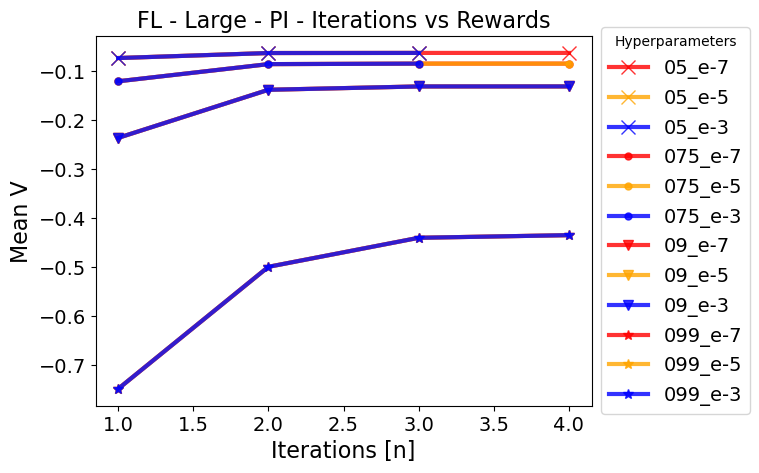

In [32]:
plt.plot(pi_df_05_e7['Iteration'],pi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(pi_df_05_e5['Iteration'],pi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5')
plt.plot(pi_df_05_e3['Iteration'],pi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3')

plt.plot(pi_df_075_e7['Iteration'],pi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7')
plt.plot(pi_df_075_e5['Iteration'],pi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5')
plt.plot(pi_df_075_e3['Iteration'],pi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3')

plt.plot(pi_df_09_e7['Iteration'],pi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7')
plt.plot(pi_df_09_e5['Iteration'],pi_df_09_e5['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5')
plt.plot(pi_df_09_e3['Iteration'],pi_df_09_e3['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3')

plt.plot(pi_df_099_e7['Iteration'],pi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7')
plt.plot(pi_df_099_e5['Iteration'],pi_df_099_e5['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5')
plt.plot(pi_df_099_e3['Iteration'],pi_df_099_e3['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3')


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Large - PI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
#plt.xscale('log')

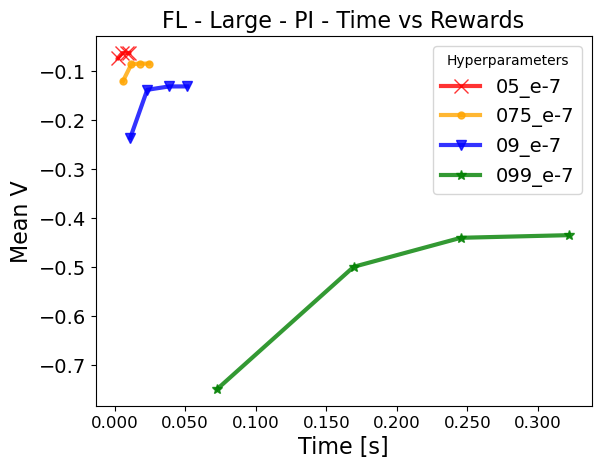

In [33]:
plt.plot(pi_df_05_e7['Time'],pi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(pi_df_075_e7['Time'],pi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(pi_df_09_e7['Time'],pi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(pi_df_099_e7['Time'],pi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')

plt.xlabel("Time [s]",fontsize = 16)

plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FL - Large - PI - Time vs Rewards', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 

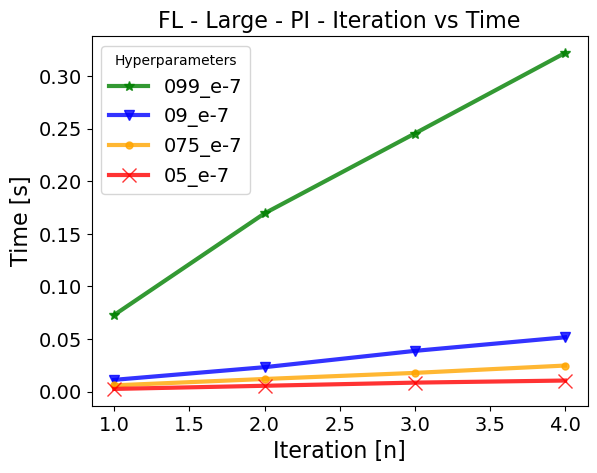

In [34]:
plt.plot(pi_df_099_e7['Iteration'],pi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
plt.plot(pi_df_09_e7['Iteration'],pi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(pi_df_075_e7['Iteration'],pi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(pi_df_05_e7['Iteration'],pi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')

plt.xlabel("Iteration [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Large - PI - Iteration vs Time', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

In [61]:
best_policy = np.array(list(pi_df.loc[11]["Policy"]))
best_policy

array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])

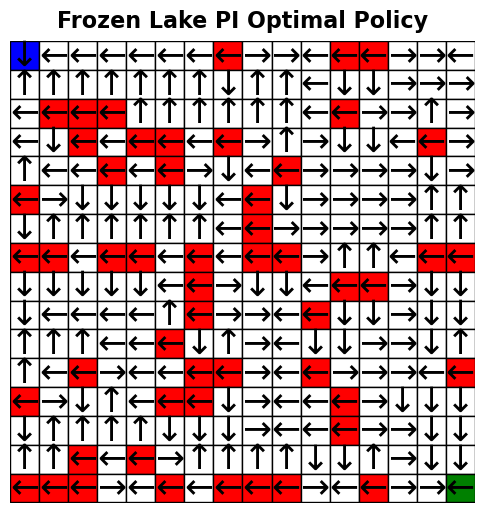

In [36]:
best_policy = np.array(list(pi_df.loc[2]["Policy"]))
best_policy = best_policy.reshape(rows, cols)
title='Frozen Lake PI Optimal Policy'
plot_lake(env, best_policy, title='Frozen Lake PI Optimal Policy')

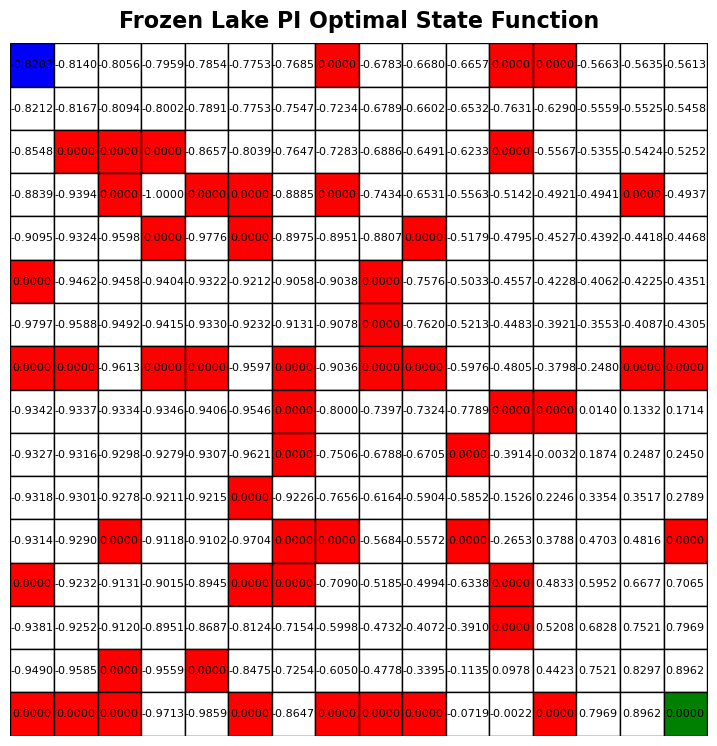

In [39]:
best_val_fn = np.array(list(pi_df.loc[2]["Value Function"]))
best_val_fn = best_val_fn.reshape(rows, cols)
plot_lake_values(env, best_val_fn, title='Frozen Lake PI Optimal State Function')